<a href="https://colab.research.google.com/github/x10cll/QM2/blob/main/Project0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving 90571275623.csv to 90571275623 (1).csv
User uploaded file "90571275623 (1).csv" with length 8891264 bytes


In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-2294245314.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["datetime"] = pd.to_datetime(data["datetime"], errors="coerce")
/tmp/ipython-input-2294245314.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["pm25"]


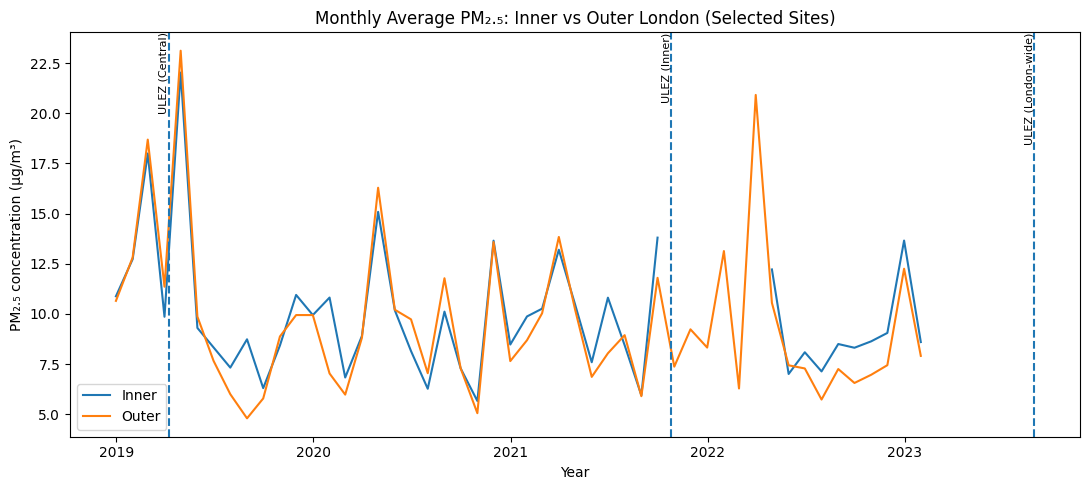

Rows used: 88131
Date range: 2018-12-01 00:00:00 to 2023-01-01 00:00:00

Observations per site:
site
London Bexley        33203
Camden Kerbside      29710
London Bloomsbury    25218
Name: count, dtype: int64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) CONFIG
# =========================

RAW_PATH = "90571275623 (1).csv"

# Exact site names as shown in the file
INNER_SITES = [
    "Camden Kerbside",
    "London Bloomsbury",
]

OUTER_SITES = [
    "London Bexley",
]

ULEZ_LINES = [
    ("2019-04-08", "ULEZ (Central)"),
    ("2021-10-25", "ULEZ (Inner)"),
    ("2023-08-29", "ULEZ (London-wide)"),
]

# =========================
# 1) LOAD + CLEAN (wide -> tidy)
# =========================

raw = pd.read_csv(RAW_PATH, low_memory=False)
raw = raw.dropna(axis=1, how="all")

# Site names row
site_row = raw.iloc[2]

# Actual data
data = raw.iloc[5:].copy()

# Rename columns using site names
new_cols = []
for col, site in zip(data.columns, site_row):
    if pd.notna(site) and str(site).strip() != "":
        new_cols.append(str(site).strip())
    else:
        new_cols.append(col)
data.columns = new_cols

# Datetime
data.rename(columns={data.columns[0]: "datetime"}, inplace=True)
data["datetime"] = pd.to_datetime(data["datetime"], errors="coerce")
data = data.dropna(subset=["datetime"])

# Keep numeric measurement columns only
value_cols = [
    c for c in data.columns
    if c != "datetime" and "Status" not in str(c)
]

for c in value_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# Tidy format
tidy = data.melt(
    id_vars="datetime",
    value_vars=value_cols,
    var_name="site",
    value_name="pm25"
).dropna(subset=["pm25"])

# =========================
# 2) LABEL INNER / OUTER
# =========================

SITE_AREA = {s: "Inner" for s in INNER_SITES}
SITE_AREA.update({s: "Outer" for s in OUTER_SITES})

tidy = tidy[tidy["site"].isin(SITE_AREA.keys())].copy()
tidy["area"] = tidy["site"].map(SITE_AREA)

# =========================
# 3) MONTHLY MEAN
# =========================

monthly = (
    tidy
    .set_index("datetime")
    .groupby(["area", "site"])
    .resample("M")["pm25"]
    .mean()
    .reset_index()
)

area_monthly = (
    monthly
    .groupby(["area", "datetime"])["pm25"]
    .mean()
    .reset_index()
)

# =========================
# 4) LINE CHART
# =========================

fig, ax = plt.subplots(figsize=(11, 5))

for area in ["Inner", "Outer"]:
    sub = area_monthly[area_monthly["area"] == area]
    ax.plot(sub["datetime"], sub["pm25"], label=area)

for date_str, label in ULEZ_LINES:
    ax.axvline(pd.to_datetime(date_str), linestyle="--")
    ax.text(
        pd.to_datetime(date_str),
        ax.get_ylim()[1],
        label,
        rotation=90,
        va="top",
        ha="right",
        fontsize=8
    )

ax.set_title("Monthly Average PM₂.₅: Inner vs Outer London (Selected Sites)")
ax.set_xlabel("Year")
ax.set_ylabel("PM₂.₅ concentration (µg/m³)")
ax.legend()

plt.tight_layout()
plt.show()

# =========================
# 5) SANITY CHECK
# =========================

print("Rows used:", len(tidy))
print("Date range:", tidy["datetime"].min(), "to", tidy["datetime"].max())
print("\nObservations per site:")
print(tidy["site"].value_counts())